In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset("titanic")

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


La **classification** est une tâche de ML qupervisée qui consiste à prédire une catégorie.

**Types de classification**:
- **Binaire** : 2 classe (Survivant/Décédé)
- **Multi-class** : > 2 classes

**Algorithme courant** :
- Régression logistique
- Arbre de décision
- Random Forest

# Analyse exploratoire

Text(0, 0.5, 'taux de survie')

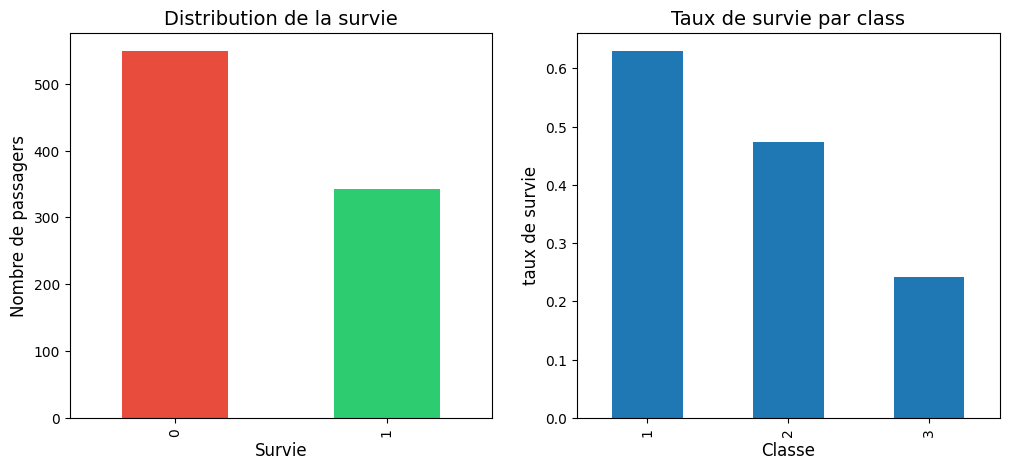

In [ ]:
plt.figure(figsize=(12, 5))

# Distribution globale de la survie
plt.subplot(121)
titanic["survived"].value_counts().plot(kind="bar", color=["#E74C3C", "#2ECC71"])
plt.title("Distribution de la survie", fontsize=14)
plt.xlabel("Survie", fontsize=12)
plt.ylabel("Nombre de passagers", fontsize=12)

plt.subplot(122)
survival_class = titanic.groupby("pclass")["survived"].mean()
survival_class.plot(kind="bar")
plt.title("Taux de survie par class", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("taux de survie", fontsize=12)

# Gestion des valeurs manquantes

In [ ]:
def analyse_missing_date(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    df_missing = pd.DataFrame(
        {
            "Colonnes": missing.index,
            "Valeurs manquantes": missing.values,
            "Pourcentages": missing_pct.values,
        }
    )
    df_missing = df_missing[df_missing["Valeurs manquantes"] > 0].sort_values(
        "Pourcentages", ascending=False
    )
    return df_missing


missing_data = analyse_missing_date(titanic)
missing_data

,Colonnes,Valeurs manquantes,Pourcentages
11,deck,688,77.216611
3,age,177,19.865320
7,embarked,2,0.224467
12,embark_town,2,0.224467


# Prétraitement des données

In [5]:
features_to_keep = ["pclass", "sex", "age", "sibsp", "fare", "parch", "embarked"]
target = "survived"

X = titanic[features_to_keep].copy()
y = titanic[target].copy()

# Identifiation des types de colonnes
numeric_features = X.select_dtypes(include=["int", "float"]).columns.to_list()
categorical_features = X.select_dtypes(include=["object"]).columns.to_list()

print(f"Variables numériques : {numeric_features}")
print(f"Variables catégorielles : {categorical_features}")

Variables numériques : ['pclass', 'age', 'sibsp', 'fare', 'parch']
Variables catégorielles : ['sex', 'embarked']


## Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="median"),
        ),  # remplacer les NaN par la médiane
        ("scaler", StandardScaler()),  # Normaliser les données
    ]
)

# Pipeline pour les variables catégorielles
categorical_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="constant", fill_value="missing"),
        ),  # remplacer les NaN par "missing"
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Appliquer les pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Séparation Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% test 80% train
    random_state=42,  # seed
    stratify=y,  # Déséquilibre des classes
    shuffle=True,
)

print(f"Train : {y_train.mean():.1%} de survivants")
print(f"Train : {y_test.mean():.1%} de survivants")

Train : 38.3% de survivants
Train : 38.5% de survivants


## Régression logistique

Malgré son nom, la régression logistique est un algorithme de classification.

- Le seuil de décision (par défaut 0.5) : si P > 0.5 => classe 1, sinon classe 0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

ml_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),  # Transformation des données
        ("classifier", LogisticRegression(random_state=42, max_iter=1_000)),  # Modèle
    ]
)

# Entrainement du modèle sur les données d'entraînement
ml_pipeline.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = ml_pipeline.predict(X_test)

# Calcul du taux de bonnes prédictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2%}")

Accuracy : 80.45%


## Sauvegarde du modèle

**joblib** permet de sauvegarder un modèle entraîné pour :
- Eviter de ré-entraîner le modèle à chaque utilisation
- Déployer en production
- Partager

La pipeline complète (preprocessing + modèle) est sauvegardé.

In [9]:
import joblib

# Sauvegarde dans un fichier pkl
model_file_name = "C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/demos/titanic_survival_model.pkl"
joblib.dump(ml_pipeline, model_file_name)

['C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/demos/titanic_survival_model.pkl']

In [ ]:
# Chargement du modèle

load_model = joblib.load(model_file_name)

new_passenger = pd.DataFrame(
    {
        "pclass": [1],
        "sex": ["male"],
        "age": [30],
        "sibsp": [0],
        "fare": [80],
        "parch": [0],
        "embarked": ["S"],
    }
)

prediction = load_model.predict(new_passenger)
proba = load_model.predict_proba(new_passenger)

print(f"Survie : {'OUI' if prediction[0] == 1 else 'NON'}")
print(f"proba survie : {proba[0][1]:.1%}")

Survie : NON
proba survie : 49.2%


## Evaluation du modèle

- **Précision** : Parmi les prédictions positives, combien sont correectes ?
- **Recall** : Parmi les vrais positifs, combien ont été détectés ?
  - Important quand les faux négatifs sont coûteux
- **F1-score** : Moyenne harmonique precision*recall/(precision+recall)

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

print(classification_report(y_test, y_pred, target_names=["Décédé", "Vivant"]))

              precision    recall  f1-score   support

      Décédé       0.81      0.89      0.85       110
      Vivant       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



<Figure size 1200x700 with 0 Axes>

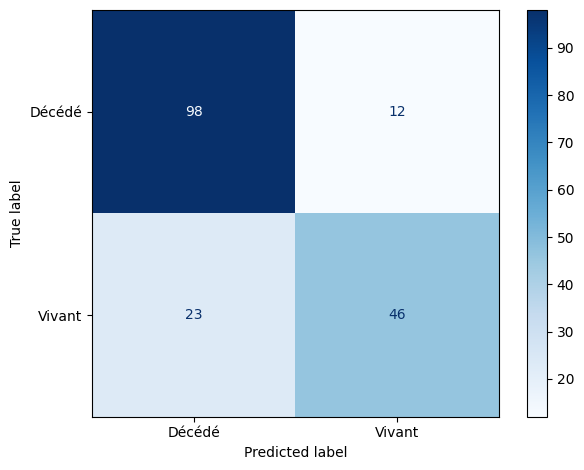

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
display = ConfusionMatrixDisplay(cm, display_labels=["Décédé", "Vivant"])
display.plot(cmap="Blues")
plt.tight_layout()

## Comparaison des modèles de classification

- **KNN** (K-Nearest Neighbors)
- **Decision Tree** (Arbre de décision)
- **Random Forest** (Forêt aléatoire)
- **Ensemble learning** (Vote majoritaire)

### KNN

**KNN** est un algorithme basé sur la proximité
- Pour prédire la classe d'un nouvelle observation :
  - trouver les **K** voisin les plus proches
  - Regarde leirs classes
  - Prédit la classe majoritaire parmi ces K voisins

**Avantages** :
- Trés simple à comprendre
- Fonction bien avec peu de données

**Inconvénients** :
- Très lent sur de gros dataset
- Très dépendant de la valeur K

In [14]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipeline = Pipeline(
    steps=[("processor", preprocessor), ("classifier", KNeighborsClassifier())]
)

kn_pipeline.fit(X_train, y_train)

y_pred_kn = kn_pipeline.predict(X_test)

print("Accuracy : ", accuracy_score(y_test, y_pred_kn))
print(classification_report(y_test, y_pred_kn))

Accuracy :  0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



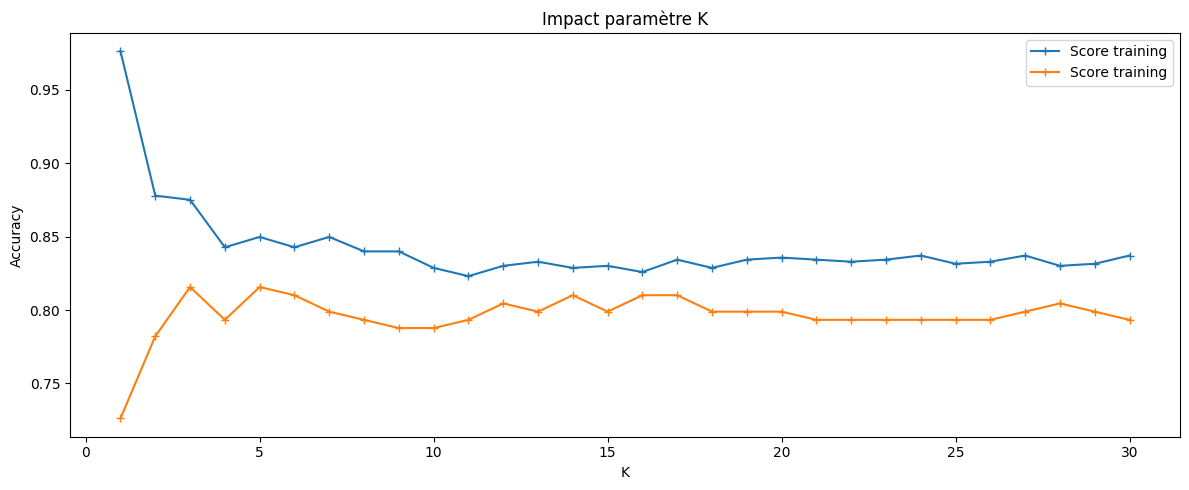

In [21]:
k_values = range(1, 31)
train_score = []
test_score = []

for k in k_values:
    knn = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", KNeighborsClassifier(n_neighbors=k)),
        ]
    )
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))

plt.figure(figsize=(12, 5))
plt.plot(k_values, train_score, label="Score training", marker="+")
plt.plot(k_values, test_score, label="Score training", marker="+")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Impact paramètre K")
plt.legend()
plt.tight_layout()

### Decision Tree

Un arbre de décision prend des décisions séquentielles :

1. à chaque noeud, l'arbre trouve la meilleur question
2. la meilleur question est celle qui sépare le mieux les classes

**Avantages** :
- Très interpretable (on peut visualiser l'arbre)
- Gère automatiquement les features catégorielles et numérique
- Pas besoin de normalisation
- Capture les relations non-linéaires

**Inconvénient** :
- Tendance à l'*overfitting*

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(
    steps=[
        ("processor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

dt_pipeline.fit(X_train, y_train)

y_train_pred_dt = dt_pipeline.predict(X_train)
y_test_pred_dt = dt_pipeline.predict(X_test)

print("Accuracy train : ", accuracy_score(y_train, y_train_pred_dt))
print("Accuracy test : ", accuracy_score(y_test, y_test_pred_dt))
print(classification_report(y_test, y_test_pred_dt))

Accuracy train :  0.9831460674157303
Accuracy test :  0.8268156424581006
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



### Random Forest

Random Forest est un ensemble d'arbres de décision.

1. Crée plusieurs arbres de décision (100 par défaut)
2. Chaque arbre est entrainé sur un échantillon aléatoire des données
3. Pour prédire : chaque arbre vote, la classe majoritaire l'emporte

**Avantages** :
- Excellentes performances
- Robuste à l'*overfitting*
- Fournit l'importance des features

**Inconvénients** :
- Moins interprétable qu'un arbre de décision
- Plus lent à entraîner et prédire
- Consomme plus de mémoire

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ("processor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

rf_pipeline.fit(X_train, y_train)

y_train_pred_rf = rf_pipeline.predict(X_train)
y_test_pred_rf = rf_pipeline.predict(X_test)

print("Accuracy train : ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test : ", accuracy_score(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

Accuracy train :  0.9831460674157303
Accuracy test :  0.8212290502793296
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

